In [43]:
import scipy.io
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx 
from scipy import integrate

# Load the .mat files
flow = scipy.io.loadmat('Data\\flow.mat')["flow"].reshape(28,)
capacities = scipy.io.loadmat('Data\\capacities.mat')["capacities"].reshape(28,)
traffic = scipy.io.loadmat('Data\\traffic.mat')["traffic"]
traveltime = scipy.io.loadmat('Data\\traveltime.mat')["traveltime"].reshape(28,)


In [44]:
G = nx.DiGraph()

number_of_edges = traffic.shape[1]
number_of_nodes = traffic.shape[0]

# Add nodes to the graph
G.add_nodes_from(range(1, number_of_nodes + 1))

# Add edges with attributes to the graph
for edge_index in range(number_of_edges):
    start_node = np.where(traffic[:, edge_index] == 1)[0][0] + 1
    end_node = np.where(traffic[:, edge_index] == -1)[0][0] + 1

    G.add_edge(start_node, end_node, 
               capacity=capacities[edge_index],
               flow=flow[edge_index],
               weight=traveltime[edge_index])




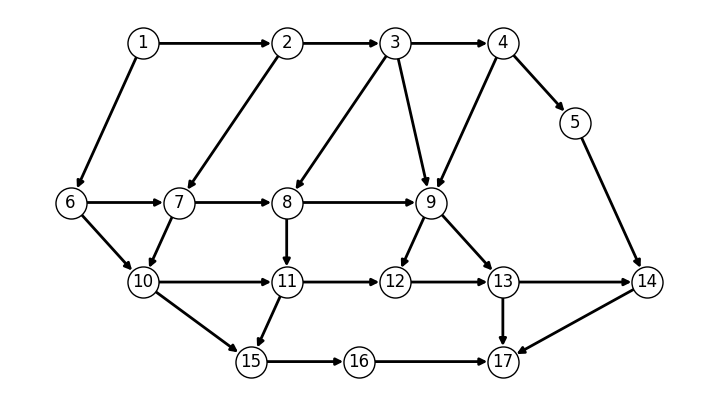

In [45]:
#draw Graph

fig, ax = plt.subplots(figsize=(9,5))

pos = {1:[-3,1], 2:[-1,1], 3:[0.5,1], 4:[2,1], 5:[3,0], 6:[-4,-1], 7:[-2.5,-1], 8:[-1,-1], 9:[1,-1], 
       10:[-3,-2], 11:[-1,-2], 12:[0.5,-2], 13:[2,-2], 14:[4,-2], 15:[-1.5,-3], 16:[0,-3], 17:[2,-3]}

nx.draw(G, pos, node_size = 500, font_size=12, node_color='white', with_labels=True, width=2,edgecolors='black', edge_color = 'black', ax=ax)

### (a) Find the Shortest Path (Fastest Path in an Empty Network)


In [46]:
# Compute the shortest path from node 1 to node 17
source_node = 1
target_node = 17

shortest_path = nx.shortest_path(G, source=source_node, target=target_node, weight='weight')
shortest_path_length = nx.shortest_path_length(G, source=source_node, target=target_node, weight='weight')

print("Shortest path (nodes):", shortest_path)
print("Shortest path length:", shortest_path_length)

Shortest path (nodes): [1, 2, 3, 9, 13, 17]
Shortest path length: 0.559833


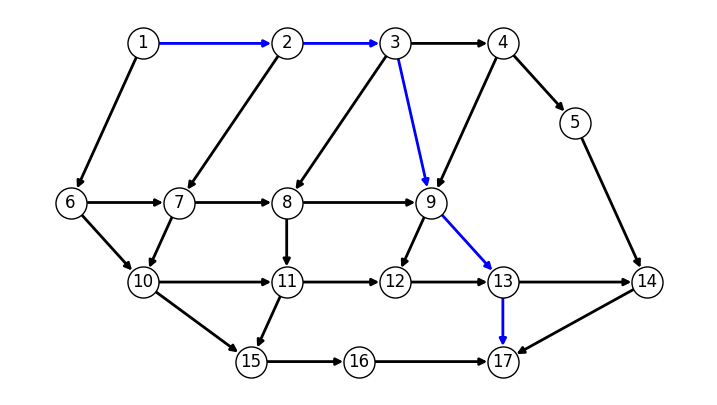

In [47]:
# Identify edges in the shortest path
shortest_path_edges = list(zip(shortest_path[:-1], shortest_path[1:]))

# Initialize edge colors to "black"
edge_colors = ["black"] * G.number_of_edges()

# Map edge indices to the graph edges
edge_list = list(G.edges)

# Set the color for edges in the shortest path
for i, edge in enumerate(edge_list):
    if edge in shortest_path_edges:
        edge_colors[i] = "blue"

# Draw the graph
fig, ax = plt.subplots(figsize=(9, 5))

nx.draw( G, pos, node_size=500, font_size=12, node_color="white",edgecolors='black', with_labels=True, width=2, edge_color=edge_colors, ax=ax,)
plt.savefig('problem3_d.pdf')


### (b) Find the Maximum Flow

In [48]:
# Calculate maximum flow using capacities
max_flow_value, flow_dict = nx.maximum_flow(G, source_node, target_node, capacity='capacity')

# Print results
print("Maximum Flow Value:", max_flow_value)
print("Flow Distribution:")
for u, flows in flow_dict.items():
    for v, f in flows.items():
        print(f"Flow from {u} to {v}: {f}")

Maximum Flow Value: 22448
Flow Distribution:
Flow from 1 to 2: 8741
Flow from 1 to 6: 13707
Flow from 2 to 3: 8741
Flow from 2 to 7: 0
Flow from 3 to 4: 0
Flow from 3 to 8: 0
Flow from 3 to 9: 8741
Flow from 4 to 5: 0
Flow from 4 to 9: 0
Flow from 5 to 14: 0
Flow from 6 to 7: 4624
Flow from 6 to 10: 9083
Flow from 7 to 8: 4624
Flow from 7 to 10: 0
Flow from 8 to 9: 4624
Flow from 8 to 11: 0
Flow from 9 to 13: 6297
Flow from 9 to 12: 7068
Flow from 10 to 11: 825
Flow from 10 to 15: 8258
Flow from 11 to 12: 825
Flow from 11 to 15: 0
Flow from 12 to 13: 7893
Flow from 13 to 14: 3835
Flow from 13 to 17: 10355
Flow from 14 to 17: 3835
Flow from 15 to 16: 8258
Flow from 16 to 17: 8258


### (c) Compute the Vector ν

In [49]:
n_edges = traffic.shape[1]
B_matrix = traffic

# external_inflow
v = B_matrix @ flow
v

array([ 16282,   9094,  19448,   4957,   -746,   4768,    413,     -2,
        -5671,   1169,     -5,  -7131,   -380,  -7412,  -7810,  -3430,
       -23544], dtype=int32)

In [50]:
nu = [ 8000,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   -8000]

### (d) Find the Social Optimum 𝑓


In [51]:
f = cp.Variable(n_edges)

#cost function 
func = cp.multiply(traveltime*capacities, cp.inv_pos(1 - cp.multiply(f,1/capacities))) - traveltime*capacities                                   
func = cp.sum(func)

# Construct the problem.
# Minimize cost function
objective = cp.Minimize(func)
constraints = [B_matrix @ f == nu, f >=0, f <= capacities]
prob = cp.Problem(objective, constraints)

# The optimal objective value is returned by `prob.solve()`.
cost_opt = prob.solve()

# The optimal value for f is stored in `f.value`.
opt_flow = f.value
print("Social optimal flow:", opt_flow)
print("Optimal cost:", cost_opt)

Social optimal flow: [3.12680434e+03 3.12680329e+03 6.86856251e+02 6.86856113e+02
 4.87319566e+03 2.25863326e+03 1.28797850e+03 9.96214934e+02
 1.68714838e+03 1.04940216e-03 1.43289165e+02 2.29665787e+03
 1.38522595e-04 6.86856113e+02 2.61456241e+03 9.19979862e+02
 2.66523835e+03 9.70655800e+02 4.35052736e+02 1.60572457e+03
 1.35503237e+03 2.96075694e+03 1.07252794e+03 2.28334351e-04
 3.57537737e+03 1.75938406e+03 2.66523857e+03 2.66523857e+03]
Optimal cost: 6792.894279502048


### (e) Find the Wardrop Equilibrium $f^{ (0)}$.

In [52]:
f = cp.Variable(n_edges)

#cost function 
integral = - cp.multiply(traveltime * capacities, cp.log( 1 - (cp.multiply(f, 1/capacities) )))
func2 = cp.sum(integral)

#minimize cost function
objective = cp.Minimize(func2)
constraints = [B_matrix @ f == nu, f >=0, f <= capacities]
prob = cp.Problem(objective, constraints)

cost_w = prob.solve()
print("Wardrop equilibrium flow:", f.value)
print(cost_w)

Wardrop equilibrium flow: [3.12619655e+03 3.12619654e+03 2.37732796e-05 1.91577284e-05
 4.87380345e+03 2.13224356e+03 1.31849279e+03 8.47143912e+02
 1.89941475e+03 7.19487522e-06 2.74330690e-05 3.12619649e+03
 4.61554531e-06 1.91577258e-05 2.74155989e+03 5.66790095e+02
 2.98852057e+03 8.13750780e+02 4.71348905e+02 2.07392566e+03
 1.03813899e+03 3.11206466e+03 6.52928942e+02 6.97809359e-06
 4.35855046e+03 6.52928961e+02 2.98852058e+03 2.98852058e+03]
5662.990798632121


Compute the cost of Wardrop equilibrium with:  
$\sum_{e \in \varepsilon} f_e \tau_e(f_e)$  



In [53]:
war_vect = f.value

def cost(f):
    tot = []
    for i, value in enumerate(f):
        tot.append(((traveltime[i]*capacities[i]) / (1-(value/capacities[i])))-traveltime[i]*capacities[i])
    return sum(tot)

cost_w = cost(war_vect) 

print("Wardrop cost:", cost_w)

Wardrop cost: 6901.711215422085




and the Price of Anarchy:  
$PoA(0) = \frac{\text{Wardrop cost}}{\text{Social optimum cost}}$


In [54]:
PoA = cost_w/cost_opt

print("The price of anarchy:", PoA)  

The price of anarchy: 1.0160192300133977


In [55]:
# Function to find all paths from source to destination using only used edges
def find_used_paths(G, flows, source, destination, threshold = 0.01):
    
    # Filter edges based on the flow threshold
    used_edges = [(u, v) for (u, v), flow in zip(G.edges(), flows) if flow > threshold]

    # Create a subgraph with only the used edges
    used_subgraph = nx.DiGraph()
    used_subgraph.add_edges_from(used_edges)

    # Find all paths from source to destination in the subgraph
    used_paths = list(nx.all_simple_paths(used_subgraph, source=source, target=destination))
    return used_paths, used_edges

# Function to draw the graph with highlighted paths using a heatmap gradient
def draw_graph_with_paths(G, pos, used_paths, path_flows, title):
    plt.figure(figsize=(7,4))

    # Draw the base graph with light edges
    nx.draw(
        G, pos, with_labels=True, node_size=500, node_color='white', edgecolors='black', width=0.5
    )

    # Normalize path flows for heatmap coloring
    max_flow = max(path_flows) if path_flows else 1
    normalized_flows = [flow / max_flow for flow in path_flows]

    for i, path in enumerate(used_paths):
        # Extract edges for the path
        path_edges = [(path[j], path[j + 1]) for j in range(len(path) - 1)]

        # Generate a color gradient from white to red (higher flow = darker red)
        color = plt.cm.Reds(normalized_flows[i])

        # Highlight the edges in the path
        nx.draw_networkx_edges(
            G, pos,
            edgelist=path_edges,
            width=2 + normalized_flows[i] * 5,  # Edge width proportional to normalized flow
            edge_color=[color],
        )

    # Add title
    plt.title(title, fontsize=14)

    # Save the figure with the title included
    # plt.savefig(title.replace(" ", "_") + ".jpg", dpi=1000, bbox_inches='tight')
    plt.show()


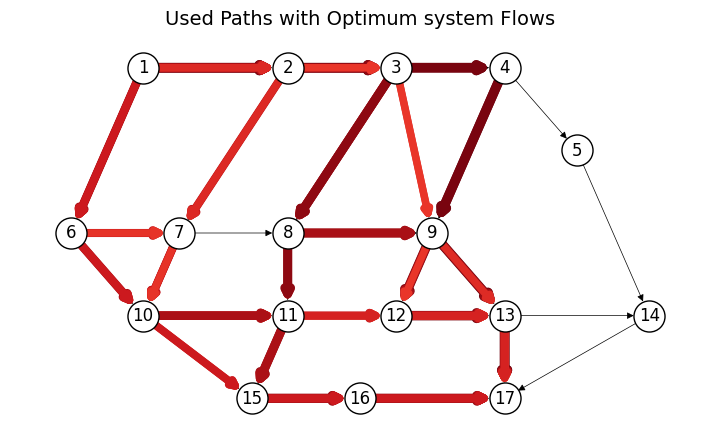

In [56]:
# Example Inputs
source = 1
destination = 17

# Find the used paths and their corresponding edges
used_paths, used_edges = find_used_paths(G, opt_flow, source, destination)

# Create a mapping of edges to their flow values
edge_to_flow = {edge: flow for edge, flow in zip(G.edges(), opt_flow)}

# Calculate path flows (sum of edge flows for simplicity)
path_flows = [sum(edge_to_flow[edge] for edge in zip(path[:-1], path[1:])) for path in used_paths]

# Draw the graph with used paths highlighted in a heatmap gradient
draw_graph_with_paths(G, pos, used_paths, path_flows, title="Used Paths with Optimum system Flows")

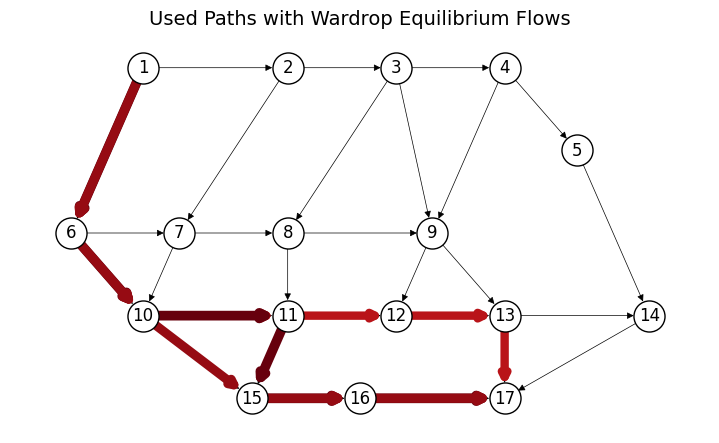

In [57]:

# Example Inputs
source = 1
destination = 17

# Find the used paths and their corresponding edges
used_paths, used_edges = find_used_paths(G, war_vect, source, destination)

# Create a mapping of edges to their flow values
edge_to_flow = {edge: flow for edge, flow in zip(G.edges(), war_vect)}

# Calculate path flows (sum of edge flows for simplicity)
path_flows = [sum(edge_to_flow[edge] for edge in zip(path[:-1], path[1:])) for path in used_paths]

# Draw the graph with used paths highlighted in a heatmap gradient
draw_graph_with_paths(G, pos, used_paths, path_flows, title="Used Paths with Wardrop Equilibrium Flows")

**F)** Introduce tolls, such that the toll on link e is $\omega _{e} = f^* _{e}{d _{e}}'(f^* _{e})$, where $f^* _{e}$ is the flow at the system optimum. compute the new Wardrop equilibrium $ f^{(w)} $.

In [58]:
f = cp.Variable(n_edges)

#compute omega
omega = []
for i, value in enumerate(opt_flow):
    omega.append(value*((capacities[i]*traveltime[i])/((capacities[i]-value)**2)))

func_f = cp.sum(cp.multiply(omega, f) - cp.multiply(capacities*traveltime, cp.log(1-(cp.multiply(f, 1/capacities)))))

objective = cp.Minimize(func_f)
constraints = [B_matrix @ f == nu, f >=0, f <= capacities]
prob = cp.Problem(objective, constraints)

result = prob.solve()

print("Wardrop equilibrium with tolls:", f.value)

Wardrop equilibrium with tolls: [3.12658556e+03 3.12658555e+03 6.86799339e+02 6.86799336e+02
 4.87341444e+03 2.25840654e+03 1.28798775e+03 9.96376569e+02
 1.68712979e+03 1.18018382e-05 1.43461404e+02 2.29632481e+03
 2.47742524e-06 6.86799336e+02 2.61500789e+03 9.20121970e+02
 2.66530473e+03 9.70418808e+02 4.35072582e+02 1.60557159e+03
 1.35519455e+03 2.96076614e+03 1.07251207e+03 3.80241167e-06
 3.57538385e+03 1.75931141e+03 2.66530474e+03 2.66530474e+03]


In [59]:
ward_toll_flow = f.value
#compute cost of wardrop equilibrium
cost_w = cost(ward_toll_flow) 

print("Wardrop cost:", cost_w)

PoA = cost_w/cost_opt

print("The price of anarchy:", PoA) 

Wardrop cost: 6792.894252013902
The price of anarchy: 0.999999995953397


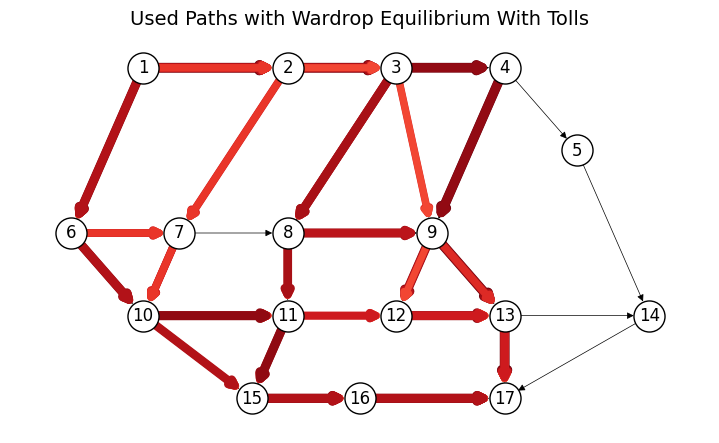

In [60]:
# Example Inputs
source = 1
destination = 17

# Find the used paths and their corresponding edges
used_paths, used_edges = find_used_paths(G, ward_toll_flow, source, destination)

# Create a mapping of edges to their flow values
edge_to_flow = {edge: flow for edge, flow in zip(G.edges(), war_vect)}

# Calculate path flows (sum of edge flows for simplicity)
path_flows = [sum(edge_to_flow[edge] for edge in zip(path[:-1], path[1:])) for path in used_paths]

# Draw the graph with used paths highlighted in a heatmap gradient
draw_graph_with_paths(G, pos, used_paths, path_flows, title="Used Paths with Wardrop Equilibrium With Tolls")